In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [41]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confusing', 'confused', 'stuck', 'puzzling', 'puzzled'],
    'Expectation' : ['expect', 'hope', 'anticipate'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor'] # 'like better', 'go for'
}

In [5]:
with open("part_1.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

["Okay, I'm starting with a website now and immediately it has a ton of numbers, which is a little bit intimidating for me.", "I'm sure it's fine and then I'm assuming this has cookies.", "I'm fine with those.", 'Okay.', 'Coronavirus in the Slovak Republic very cool I like how it has all the stats here\njust seems a little bit overwhelming.', 'I wonder this sticks out to me as well.', "Total number of recovered patients let's increase it just except fix there's no number there okay so there's a lot of vaccinated people here I'm learning so much already okay I'm traveling I don't need to travel there so I'm assuming you don't need to register.", 'Maybe.', 'Oh, okay read about traveling.', 'cool like that.', "It's a little bit small, but I figured it out.", 'Okay, current measures, travel and immigration.', "Let's see current measures rules for establishments wearing face masks or respirator let's learn about that because I'm, I'm interested in that actually face masks.", 'Oh, depends on

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['Okay I am starting with a website now and immediately it has a ton of numbers which is a little bit intimidating for me', 'I am sure it has it is fine and then I am assuming this has cookies', 'I am fine with those', 'Okay', 'Coronavirus in the Slovak Republic very cool I like how it has all the stats here\njust seems a little bit overwhelming', 'I wonder this sticks out to me as well', 'Total number of recovered patients let us increase it just except fix there has there is no number there okay so there has there is a lot of vaccinated people here I am learning so much already okay I am traveling I do not need to travel there so I am assuming you do not need to register', 'Maybe', 'Oh okay read about traveling', 'cool like that', 'it has it is a little bit small but I figured it out', 'Okay current measures travel and immigration', 'let us see current measures rules for establishments wearing face masks or respirator let us learn about that because I am I am interested in that actua

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('Okay', 'n'), ('I', None), ('am', 'v'), ('starting', 'v'), ('with', None), ('a', None), ('website', 'n'), ('now', 'r'), ('and', None), ('immediately', 'r'), ('it', None), ('has', 'v'), ('a', None), ('ton', 'n'), ('of', None), ('numbers', 'n'), ('which', None), ('is', 'v'), ('a', None), ('little', 'a'), ('bit', 'n'), ('intimidating', 'v'), ('for', None), ('me', None)], [('I', None), ('am', 'v'), ('sure', 'a'), ('it', None), ('has', 'v'), ('it', None), ('is', 'v'), ('fine', 'a'), ('and', None), ('then', 'r'), ('I', None), ('am', 'v'), ('assuming', 'v'), ('this', None), ('has', 'v'), ('cookies', 'n')], [('I', None), ('am', 'v'), ('fine', 'a'), ('with', None), ('those', None)], [('Okay', 'n')], [('Coronavirus', 'n'), ('in', None), ('the', None), ('Slovak', 'n'), ('Republic', 'n'), ('very', 'r'), ('cool', 'v'), ('I', None), ('like', None), ('how', None), ('it', None), ('has', 'v'), ('all', None), ('the', None), ('stats', 'n'), ('here', 'r'), ('just', 'r'), ('seems', 'v'), ('a', None), ('

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['Okay', 'I', 'be', 'start', 'with', 'a', 'website', 'now', 'and', 'immediately', 'it', 'have', 'a', 'ton', 'of', 'number', 'which', 'be', 'a', 'little', 'bit', 'intimidate', 'for', 'me'], ['I', 'be', 'sure', 'it', 'have', 'it', 'be', 'fine', 'and', 'then', 'I', 'be', 'assume', 'this', 'have', 'cooky'], ['I', 'be', 'fine', 'with', 'those'], ['Okay'], ['Coronavirus', 'in', 'the', 'Slovak', 'Republic', 'very', 'cool', 'I', 'like', 'how', 'it', 'have', 'all', 'the', 'stats', 'here', 'just', 'seem', 'a', 'little', 'bit', 'overwhelming'], ['I', 'wonder', 'this', 'stick', 'out', 'to', 'me', 'as', 'well'], ['Total', 'number', 'of', 'recovered', 'patient', 'let', 'us', 'increase', 'it', 'just', 'except', 'fix', 'there', 'have', 'there', 'be', 'no', 'number', 'there', 'okay', 'so', 'there', 'have', 'there', 'be', 'a', 'lot', 'of', 'vaccinated', 'people', 'here', 'I', 'be', 'learn', 'so', 'much', 'already', 'okay', 'I', 'be', 'travel', 'I', 'do', 'not', 'need', 'to', 'travel', 'there', 'so', 'I

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['okay', 'start', 'website', 'immediately', 'ton', 'number', 'little', 'bit', 'intimidate'], ['sure', 'fine', 'assume', 'cooky'], ['fine'], ['okay'], ['coronavirus', 'slovak', 'republic', 'cool', 'like', 'stats', 'seem', 'little', 'bit', 'overwhelming'], ['wonder', 'stick', 'well'], ['total', 'number', 'recovered', 'patient', 'let', 'us', 'increase', 'except', 'fix', 'no', 'number', 'okay', 'lot', 'vaccinated', 'people', 'learn', 'much', 'already', 'okay', 'travel', 'not', 'need', 'travel', 'assume', 'not', 'need', 'register'], ['maybe'], ['oh', 'okay', 'read', 'travel'], ['cool', 'like'], ['little', 'bit', 'small', 'figure'], ['okay', 'current', 'measure', 'travel', 'immigration'], ['let', 'us', 'see', 'current', 'measure', 'rule', 'establishment', 'wear', 'face', 'mask', 'respirator', 'let', 'us', 'learn', 'interested', 'actually', 'face', 'mask'], ['oh', 'depend', 'degree', 'warning', 'accord', 'covid', 'automation', 'interest'], ['different'], [], ['okay'], ['rules', 'indoors'], [

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
}

analyzer.lexicon.update(new_words)

In [42]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word is v:
                    cat_list.append(k)
                    return k
    if cat_list:
        return cat_list
    return None

In [43]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [44]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)
    
    print(line)
    
    sent_cat = search(sentiment_category, line)
    print(sent_cat)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

['okay', 'start', 'website', 'immediately', 'ton', 'number', 'little', 'bit', 'intimidate']
None
['sure', 'fine', 'assume', 'cooky']
None
['fine']
None
['okay']
None
['coronavirus', 'slovak', 'republic', 'cool', 'like', 'stats', 'seem', 'little', 'bit', 'overwhelming']
None
['wonder', 'stick', 'well']
None
['total', 'number', 'recovered', 'patient', 'let', 'us', 'increase', 'except', 'fix', 'no', 'number', 'okay', 'lot', 'vaccinated', 'people', 'learn', 'much', 'already', 'okay', 'travel', 'not', 'need', 'travel', 'assume', 'not', 'need', 'register']
None
['maybe']
None
['oh', 'okay', 'read', 'travel']
None
['cool', 'like']
None
['little', 'bit', 'small', 'figure']
None
['okay', 'current', 'measure', 'travel', 'immigration']
None
['let', 'us', 'see', 'current', 'measure', 'rule', 'establishment', 'wear', 'face', 'mask', 'respirator', 'let', 'us', 'learn', 'interested', 'actually', 'face', 'mask']
None
['oh', 'depend', 'degree', 'warning', 'accord', 'covid', 'automation', 'interest']
No

In [21]:
df_azure_speech.to_csv("part-1-results.csv")

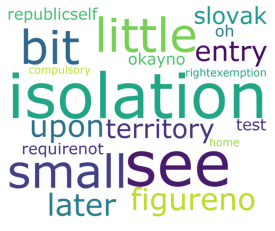

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

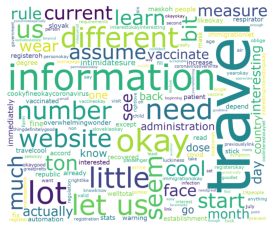

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,"Okay, I'm starting with a website now and imme...",okay start website immediately ton number litt...,0.500000,0.291,0.164,0.545,0.1027,Positive,None
1,I'm sure it's fine and then I'm assuming this ...,sure fine assume cooky,0.694444,0.672,0.000,0.328,0.4767,Positive,None
2,I'm fine with those.,fine,0.500000,1.000,0.000,0.000,0.2023,Positive,None
3,Okay.,okay,0.500000,1.000,0.000,0.000,0.2263,Positive,None
4,Coronavirus in the Slovak Republic very cool I...,coronavirus slovak republic cool like stats se...,0.716667,0.375,0.000,0.625,0.5859,Positive,None
...,...,...,...,...,...,...,...,...,...
76,It's a great website.,great website,0.750000,0.804,0.000,0.196,0.6249,Positive,None
77,It has everything I look for when trying to de...,everything look try decide need travel,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
78,The statistics in the beginning are a little o...,statistic beginning little overwhelming many w...,0.622222,0.245,0.209,0.545,0.2023,Positive,None
79,"Overall though, it had more than enough inform...",overall though enough information point would ...,0.444444,0.286,0.000,0.714,0.4939,Positive,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

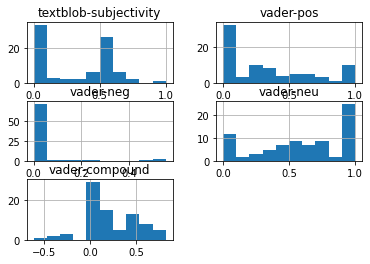

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

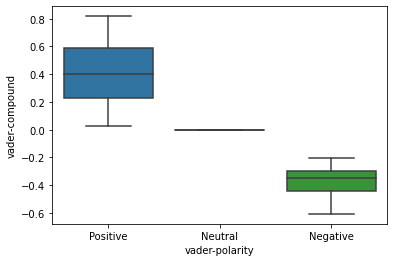

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

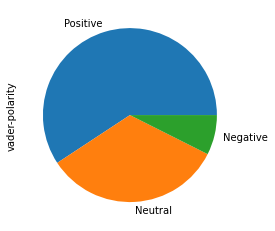

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
58,"I don't see oh, no, I do see it right here.",not see oh no see right,0.535714,0.000,0.554,0.446,-0.6072,Negative,None
10,"It's a little bit small, but I figured it out.",little bit small figure,0.450000,0.000,0.500,0.500,-0.4588,Negative,None
71,To their exemptions from compulsory home isola...,exemption compulsory home isolation,0.000000,0.000,0.474,0.526,-0.4019,Negative,None
55,No test is required.,no test require,0.000000,0.000,0.524,0.476,-0.2960,Negative,None
33,No later and upon entry in the territory of Sl...,no later upon entry territory slovak republic,0.000000,0.000,0.268,0.732,-0.2960,Negative,None
43,"Self isolation, okay.",self isolation okay,0.500000,0.339,0.482,0.179,-0.2023,Negative,None
38,So I'm assuming this is just for what country ...,assume country come,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
27,Traveling to Slovakia that's what I would need...,traveling slovakia would need foreign affair,0.125000,0.000,0.000,1.000,0.0000,Neutral,None
26,That's what I would have to do.,would,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
39,Where?,,0.000000,0.000,0.000,0.000,0.0000,Neutral,None


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
68,"Okay, so if I go just back over here, it has a...",okay go back information need seem like great,0.416667,0.630,0.000,0.370,0.8176,Positive,None
49,"Okay, so it's it's interesting how it's that s...",okay interest person non vaccinate tuck also i...,0.302381,0.233,0.000,0.767,0.7650,Positive,None
69,So I'm pretty impressed with it.,pretty impressed,1.000000,1.000,0.000,0.000,0.7430,Positive,None
73,"Okay, so I'm wearing a lot just beyond what I ...",okay wear lot beyond would know great,0.625000,0.545,0.000,0.455,0.7184,Positive,None
12,Let's see current measures rules for establish...,let us see current measure rule establishment ...,0.333333,0.263,0.000,0.737,0.6908,Positive,None
75,It looks like I have found all the information...,look like find information need,0.000000,0.647,0.000,0.353,0.6705,Positive,None
18,"Interesting, interesting.",interesting interesting,0.500000,1.000,0.000,0.000,0.6597,Positive,None
80,I especially appreciated the guidelines on fac...,especially appreciate guideline facemasks diff...,0.566667,0.274,0.000,0.726,0.6478,Positive,None
48,I love that vaccinated person.,love vaccinate person,0.600000,0.677,0.000,0.323,0.6369,Positive,None
76,It's a great website.,great website,0.750000,0.804,0.000,0.196,0.6249,Positive,None
